In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')

In [35]:
from scipy import stats
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import plotly.graph_objects as go
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

!pip install openpyxl


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


### Overview

Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

### Business Objectives

We are going to analysis the Customers based on below 3 factors:

R (Recency): Number of days since last purchase

F (Frequency): Number of transactions

M (Monetary): Total amount of transactions (revenue contributed)

This is with the aim to more effectively group customers for purposes such as marketing campaigns and customer engagement.

# Reading and understanding data

In [3]:
# Reading the data

data =  pd.read_excel('data/online_retail.xlsx', index_col=0)  

In [4]:
# Copying to a dummy variable

df = data.copy()

In [5]:
# Examining the head of the data

df.head()

,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
InvoiceNo,,,,,,,
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
# Examining the shape of the data 

df.shape

(541909, 7)

In [7]:
# Describing the data to understand outliers

df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Data Cleansing

In [8]:
# Including CustomerID as a feature not the index

df.reset_index(inplace = True)

In [9]:
# Understanding how many nulls there are

df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
# What proportion of our features are nulls

df_null = round(100*(df.isnull().sum())/len(df), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [11]:
# Removing these null values

df = df.dropna()

In [12]:
# Changing InvoiceNo to string as it has entries with letters

df = df.astype({'InvoiceNo':str})

# Data Preperation

In [13]:
# Creating new features of Recency, OrderValue and converting InvoiceDate to datetime

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["OrderValue"] = df["Quantity"] * df["UnitPrice"]
last_date = max(df['InvoiceDate']) + datetime.timedelta(days=1)

In [14]:
# First we group by invoice data so that each invoice is only counted once

invoices = df.groupby(['InvoiceNo']).agg({'OrderValue': 'sum',
                                       'InvoiceDate': lambda x: (last_date - x.max()).days,
                                       'CustomerID' : 'mean'})

In [15]:
# Including invoices in the features again

invoices.reset_index(inplace=True)

In [16]:
# Examining invoices

invoices.head()

,InvoiceNo,OrderValue,InvoiceDate,CustomerID
0,536365,139.12,374,17850.0
1,536366,22.20,374,17850.0
2,536367,278.73,374,13047.0
3,536368,70.05,374,13047.0
4,536369,17.85,374,13047.0


In [17]:
# Removing the doubling effect from cancelled orders - cancelling them out with their original order values. 
# This happens automatically with their value as it appears negative

def frequency_func(series):
    result = 0 
    unique_numbers = list(set([i for i in series]))
    for number in unique_numbers:
        if number[0] == 'C':
            result += -1
        else:
            result += 1
    return result

In [18]:
# Grouping by customer to get final results for Recency, Frequency and MonetaryValue

customers = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (last_date - x.max()).days,
                                            'InvoiceNo': frequency_func,
                                            'OrderValue': 'sum'})

In [19]:
customers.rename(columns = {'InvoiceDate': 'Recency','InvoiceNo': 'Frequency',
                            'OrderValue': 'MonetaryValue'}, inplace=True)

In [20]:
customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,0,0.00
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [21]:
# Removing all customers who have <0 frequency or monetary value - these have appeared due to cancelled orders

customers = customers[customers['Frequency'] > 0]

In [22]:
# Down to 4114 customers

customers.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4032 entries, 12347.0 to 18287.0
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        4032 non-null   int64  
 1   Frequency      4032 non-null   int64  
 2   MonetaryValue  4032 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 126.0 KB


## Outlier Analysis

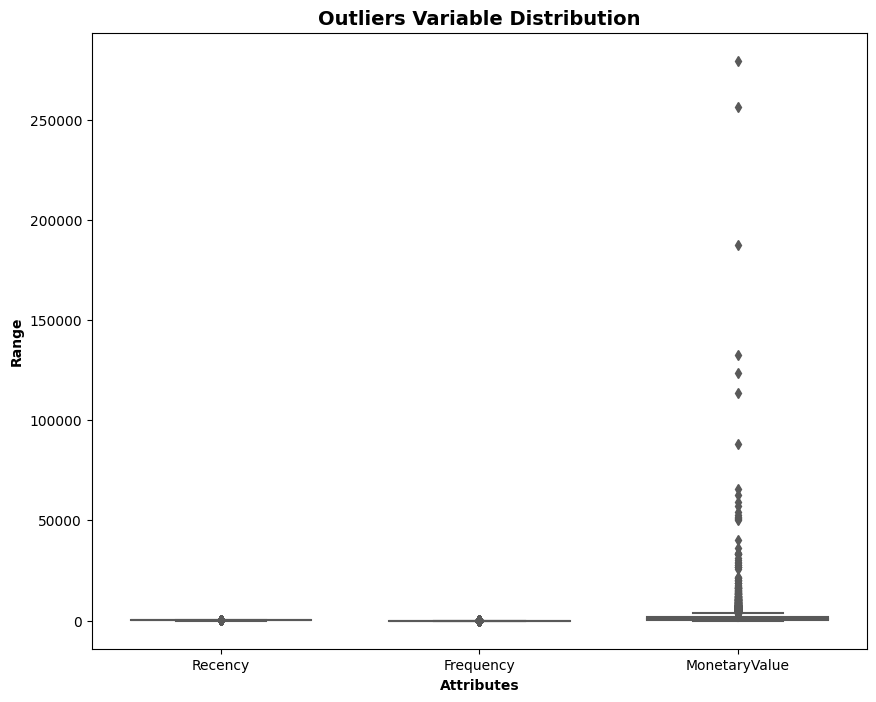

In [23]:
# K-Means is very sensitive to outliers (as it is centred on the mean) so we need to be careful before modelling

attributes = customers.columns
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = customers[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold');

In [24]:
# Clearly we have an issue with the outliers for MonetaryValue which heavily affect K-Means clustering. 
# We will remove statistical outliers to account for this and adjust the data.

# Removing (statistical) outliers for Amount
Q1 = customers['MonetaryValue'].quantile(0.05)
Q3 = customers['MonetaryValue'].quantile(0.95)
IQR = Q3 - Q1
customers = customers[(customers['MonetaryValue'] >= Q1 - 1.5*IQR) & (customers['MonetaryValue'] <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = customers['Recency'].quantile(0.05)
Q3 = customers['Recency'].quantile(0.95)
IQR = Q3 - Q1
customers = customers[(customers['Recency'] >= Q1 - 1.5*IQR) & (customers['Recency'] <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = customers['Frequency'].quantile(0.05)
Q3 = customers['Frequency'].quantile(0.95)
IQR = Q3 - Q1
customers = customers[(customers['Frequency'] >= Q1 - 1.5*IQR) & (customers['Frequency'] <= Q3 + 1.5*IQR)]

## Rescaling the data

In [25]:
ss = StandardScaler()
customers_scaled = pd.DataFrame(ss.fit_transform(customers), columns = customers.columns)

In [26]:
customers_scaled.head()

,Recency,Frequency,MonetaryValue
0,-0.886558,1.204724,1.633916
1,-0.141722,0.262445,0.252074
2,-0.713103,-0.679834,0.230247
3,2.256039,-0.679834,-0.552386
4,-0.539648,0.576538,0.113585


# Building the model

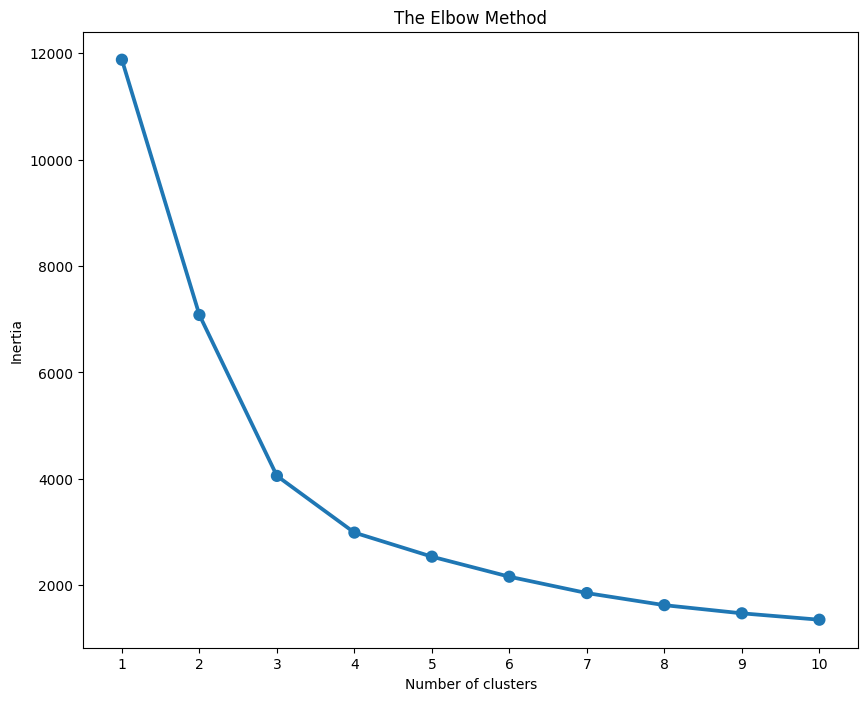

In [27]:
# Iterate K-means through clusters of size 1-11 and understand which leaves the smallest loss function (inertia)

inertias = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(customers_scaled)
    inertias[k] = kmeans.inertia_ # SSE to closest cluster centroid

#Elbow Plot    
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
sns.pointplot(x=list(inertias.keys()), y=list(inertias.values()))
plt.show()

In [28]:
# By the Elbow Method 3 seems to be a good choice for clustering

model = KMeans(n_clusters=3, random_state=42).fit(customers_scaled)

customers["Cluster"] = model.labels_


In [41]:
PLOT = go.Figure()

for C in list(customers.Cluster.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = customers[customers.Cluster == C]['Recency'],
                                y = customers[customers.Cluster == C]['Frequency'],
                                z = customers[customers.Cluster == C]['MonetaryValue'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster ' + str(C)))


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Recency', titlefont_color = 'black'),
                                yaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                zaxis=dict(title = 'MonetaryValue', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

# Interpreting model results

In [29]:
# we see that the models are relatively uneven in the following split (1:2:5)

customers['Cluster'].value_counts()

2    2595
0     932
1     432
Name: Cluster, dtype: int64

In [42]:
# Cluster significance

customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0        245.50      1.40        420.84   932
1         21.14     10.03       5256.12   432
2         43.92      2.65       1016.46  2595

We clearly see that Cluster 2 are non-recent customers, with low purchasing value and frequency.

Cluster 1 is the most valuable cluster by far, with a lifetime value of over £5,000, combined with the highest frequency
and most regular purchases.

Cluster 0 are the marginal customers who sit in the middle of the others, which is why they are over represented.

A hierarchical split of the groups through value would be 1, 0, 2. From our visualisation we can see that the imbalance between the groups is acceptable and isn't affective the affectiveness of the clusteirng